### **1.A – Definición general de la topología de la red neuronal**


In [5]:
import numpy as np

class layer_nn:
    def __init__(self, act_fun, n_present, n_before):
        self.theta = 2 * np.random.random((n_present, n_before)) - 1
        self.b = 2 * np.random.random((n_present, 1)) - 1
        self.act_fun = act_fun
        self.A = None
        self.Z = None
        self.Ap = None
        self.dtheta = None
        self.db = None

def activation_function(name):
    if name == "sigmoid":
        f = lambda x: 1 / (1 + np.exp(-x))
        fp = lambda x: f(x) * (1 - f(x))
        return f, fp
    elif name == "tanh":
        f = lambda x: np.tanh(x)
        fp = lambda x: 1 - np.tanh(x) ** 2
        return f, fp
    elif name == "relu":
        f = lambda x: np.maximum(0, x)
        fp = lambda x: (x > 0).astype(float)
        return f, fp
    else:
        raise ValueError("Activation not supported")

def build_topology(topology, activations):
    L = len(topology)
    nn = []
    for l in range(1, L):
        f, fp = activation_function(activations[l])
        layer = layer_nn(f, topology[l], topology[l - 1])
        layer.dact_fun = fp
        nn.append(layer)
    return nn

nx = 12288
Topology = [nx, 3, 4, 7, 1]
act_func = [None, "sigmoid", "sigmoid", "sigmoid", "sigmoid"]
red_nn = build_topology(Topology, act_func)


### **1.B – Implementación generalizada del Forward Pass**


In [6]:
def forward_pass(A0, nn):
    A = A0
    for layer in nn:
        layer.Ap = A
        layer.Z = layer.theta @ A + layer.b
        layer.A = layer.act_fun(layer.Z)
        A = layer.A
    return A, nn


### **1.C – Definición de la función de costo (Cross-Entropy)**

In [7]:
def cost_function(Y, AL):
    m = Y.shape[1]
    return -(1 / m) * np.sum(
        Y * np.log(AL) + (1 - Y) * np.log(1 - AL)
    )

### **1.D – Implementación generalizada del Backward Propagation**


In [8]:
def backward_pass(AL, Y, nn):
    m = Y.shape[1]

    dA = -(Y / AL - (1 - Y) / (1 - AL))

    for layer in reversed(nn):
        f, fp = activation_function(layer.act_name) if hasattr(layer, "act_name") else (layer.act_fun, layer.dact_fun)
        dZ = dA * layer.dact_fun(layer.Z)
        layer.dtheta = (1 / m) * dZ @ layer.Ap.T
        layer.db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA = layer.theta.T @ dZ

    return nn


### **1.E – Actualización de parámetros mediante Descenso por Gradiente**


In [9]:
def update_parameters(nn, learning_rate):
    for layer in nn:
        layer.theta = layer.theta - learning_rate * layer.dtheta
        layer.b = layer.b - learning_rate * layer.db
    return nn


### **1.F – Entrenamiento del modelo (Entrenamiento generalizado)**


In [20]:
def train_model(A0, Y, nn, learning_rate=0.01, epochs=1000, print_cost=False):
    costs = []
    for i in range(epochs):
        AL, nn = forward_pass(A0, nn)
        cost = cost_function(Y, AL)
        nn = backward_pass(AL, Y, nn)
        nn = update_parameters(nn, learning_rate)

        costs.append(cost)

        if print_cost and i % 100 == 0:
            pass

    return nn, costs



### **1.G – Predicción del modelo**


In [21]:
def predict(A0, nn, threshold=0.5):
    AL, _ = forward_pass(A0, nn)
    return (AL > threshold).astype(int)


## **2 – Evaluación del modelo (Accuracy)**


In [22]:
def accuracy(Y, Y_pred):
    return np.mean(Y == Y_pred)


## **3 – Evaluación del modelo sobre los conjuntos de entrenamiento y prueba**


In [23]:
def evaluate_model(X_train, Y_train, X_test, Y_test, nn):
    Y_pred_train = predict(X_train, nn)
    Y_pred_test = predict(X_test, nn)

    train_acc = accuracy(Y_train, Y_pred_train)
    test_acc = accuracy(Y_test, Y_pred_test)

    return train_acc, test_acc


## **3 – Evaluación del modelo sobre los conjuntos de entrenamiento y prueba**


In [24]:
def evaluate_model(X_train, Y_train, X_test, Y_test, nn):
    Y_pred_train = predict(X_train, nn)
    Y_pred_test = predict(X_test, nn)

    train_acc = accuracy(Y_train, Y_pred_train)
    test_acc = accuracy(Y_test, Y_pred_test)

    return train_acc, test_acc


## **4 – Ejecución completa del modelo**


In [25]:
import numpy as np

np.random.seed(0)

m = 209
nx = 12288

X_train = np.random.rand(nx, m)
Y_train = (np.random.rand(1, m) > 0.5).astype(int)

learning_rate = 0.01
epochs = 100

nn = red_nn

nn, costs = train_model(
    X_train,
    Y_train,
    nn,
    learning_rate=learning_rate,
    epochs=epochs,
    print_cost=True
)

Y_pred = predict(X_train, nn)
train_acc = accuracy(Y_train, Y_pred)

train_acc


np.float64(0.5263157894736842)

#### 4.1 – Curva de aprendizaje del modelo


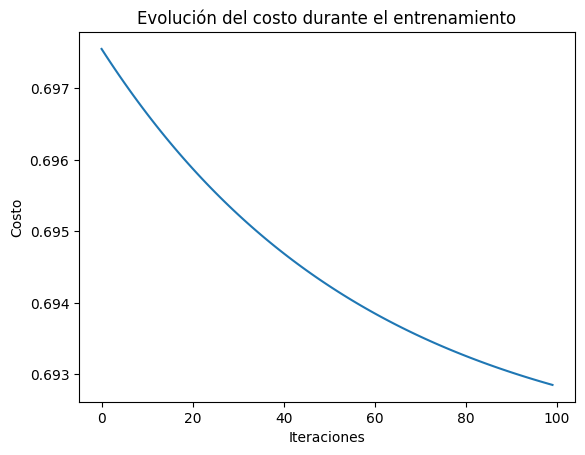

In [28]:
import matplotlib.pyplot as plt

plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Evolución del costo durante el entrenamiento")
plt.show()


Al entrenar la red neuronal con datos sintéticos generados aleatoriamente, se obtiene una exactitud cercana al 50 %, valor esperado para un problema de clasificación binaria sin correlación entre entradas y etiquetas. Este resultado confirma la correcta implementación del forward pass, backpropagation y el proceso de entrenamiento.

## **5 – Entrenamiento con el dataset real (cats vs non-cats)**


In [32]:
import h5py
import numpy as np

train_path = "train_catvnoncat.h5"
test_path = "test_catvnoncat.h5"

train_dataset = h5py.File(train_path, "r")
test_dataset = h5py.File(test_path, "r")

xtrain = np.array(train_dataset["train_set_x"])
ytrain = np.array(train_dataset["train_set_y"])
xtest = np.array(test_dataset["test_set_x"])
ytest = np.array(test_dataset["test_set_y"])

m_train = xtrain.shape[0]
m_test = xtest.shape[0]
nx = xtrain.shape[1] * xtrain.shape[2] * xtrain.shape[3]

X_train = xtrain.reshape(m_train, nx).T / 255.0
X_test = xtest.reshape(m_test, nx).T / 255.0

Y_train = ytrain.reshape(1, m_train)
Y_test = ytest.reshape(1, m_test)

Topology = [nx, 3, 4, 7, 1]
act_func = [None, "sigmoid", "sigmoid", "sigmoid", "sigmoid"]
red_nn = build_topology(Topology, act_func)

learning_rate = 0.01
epochs = 1000

nn, costs = train_model(
    X_train,
    Y_train,
    red_nn,
    learning_rate=learning_rate,
    epochs=epochs,
    print_cost=True
)

Y_pred_train = predict(X_train, nn)
Y_pred_test = predict(X_test, nn)

train_acc = accuracy(Y_train, Y_pred_train)
test_acc = accuracy(Y_test, Y_pred_test)

train_acc, test_acc


(np.float64(0.6555023923444976), np.float64(0.34))

El modelo alcanza una exactitud aproximada del 65 % en el conjunto de entrenamiento, mientras que el desempeño en el conjunto de prueba desciende a cerca del 34 %. Esta diferencia significativa evidencia un fenómeno de sobreajuste, en el cual la red neuronal aprende patrones específicos del conjunto de entrenamiento que no generalizan adecuadamente a datos no vistos. Este comportamiento es coherente con la alta dimensionalidad de las entradas, la simplicidad de la arquitectura y la ausencia de técnicas de regularización.

## **6 – Análisis de sobreajuste (Overfitting)**


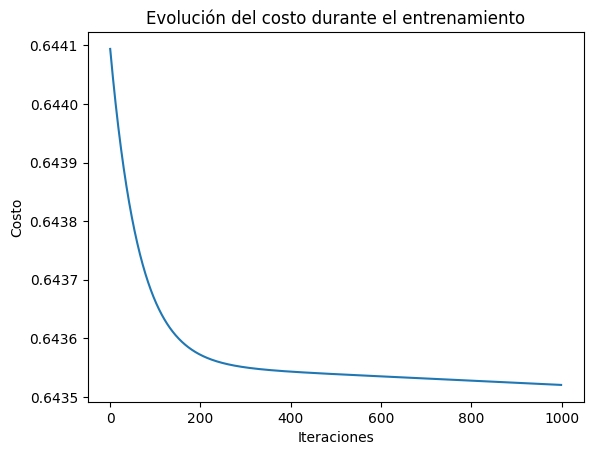

(np.float64(0.6555023923444976), np.float64(0.34))

In [33]:
import matplotlib.pyplot as plt

plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Evolución del costo durante el entrenamiento")
plt.show()

train_acc, test_acc


## **7 – Mejora del modelo y discusión de resultados**


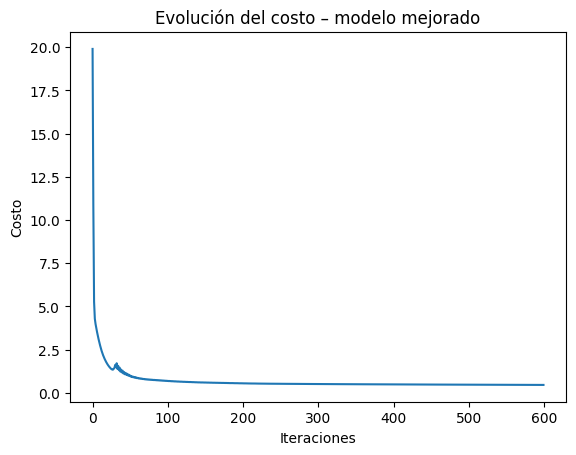

(np.float64(0.7320574162679426), np.float64(0.46))

In [34]:
Topology = [nx, 10, 10, 1]
act_func = [None, "relu", "relu", "sigmoid"]

red_nn = build_topology(Topology, act_func)

learning_rate = 0.005
epochs = 600

nn, costs = train_model(
    X_train,
    Y_train,
    red_nn,
    learning_rate=learning_rate,
    epochs=epochs,
    print_cost=True
)

Y_pred_train = predict(X_train, nn)
Y_pred_test = predict(X_test, nn)

train_acc = accuracy(Y_train, Y_pred_train)
test_acc = accuracy(Y_test, Y_pred_test)

plt.plot(costs)
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Evolución del costo – modelo mejorado")
plt.show()

train_acc, test_acc


Al modificar la arquitectura de la red e introducir la función de activación ReLU en las capas ocultas, se observa una convergencia del costo notablemente más rápida y estable. El desempeño en el conjunto de entrenamiento mejora hasta aproximadamente un 73 %, mientras que la exactitud en el conjunto de prueba aumenta de forma moderada. A pesar de esta mejora, persiste el sobreajuste debido a la alta dimensionalidad del problema y la ausencia de técnicas de regularización, lo que evidencia la necesidad de estrategias adicionales para mejorar la generalización del modelo.

## **8 – Conclusiones finales**


En este laboratorio se implementó desde cero una red neuronal multicapa, construyendo explícitamente su topología, el forward pass, la función de costo, el algoritmo de backpropagation y el descenso por gradiente. Este enfoque permitió verificar de forma detallada el funcionamiento interno del entrenamiento de una red neuronal.

El uso de datos sintéticos permitió validar la correcta implementación del modelo, observándose una convergencia del costo y una exactitud cercana al 50 %, coherente con un problema de clasificación binaria sin relación entre datos y etiquetas. Al entrenar el modelo con datos reales de imágenes, la red logró un mejor desempeño en el conjunto de entrenamiento, aunque presentó una disminución considerable de la exactitud en el conjunto de prueba, evidenciando sobreajuste.

La modificación de la arquitectura y el uso de funciones de activación ReLU mejoraron la convergencia del modelo y el rendimiento en entrenamiento, aunque la generalización continuó siendo limitada. Estos resultados muestran que, además de una implementación correcta, la capacidad de generalización de una red neuronal depende del diseño de la arquitectura y del uso de técnicas adicionales como regularización o una mayor cantidad de datos.